# Predicting bike availability for San Francisco's bike share program
Bike share programs are cropping up in cities across the world, providing a flexible transportation option for professionals and tourists alike. Bike share systems are commonly built with "docking stations" throughout the city where users can check out and return bikes. In 2013, San Francisco launched their bike share program which, as of 2015, had 70 stations throughout the city. 

Bike share programs offer challenges for both the program owners (cities) and users (riders). For example, cities often manually redistribute bikes between stations to ensure availability of both bikes and docks (slots to return bikes). Cities also need to use rider data to inform where future bike stations should be installed. For users, the main questions is: **If I leave home/work now, will there be a bike at the nearest station when I arrive?** The uncertainty of bikes at a given station also has severe business implications, as unpredictable bike supply can deter ridership and stagnate demand. This project focuses on user challenges of bike availability.

This project evaluates current ridership trends and seeks to predict bike availability (within 30 minutes of a request) for the San Francisco bike share system. The three main sections of this project include: exploratory data analysis, a simple deterministic model, and two versions of machine learned models. Comparative evaluation of the models indicates that the machine learned model with advanced feature engineering indeed out-performs the deterministic and naive machine learning model.

The following publicly available data are used (source: https://www.kaggle.com/benhamner/sf-bay-area-bike-share/data): 
- status: minute-by-minute update of the number of bikes and number of docks available for each of the 70 stations
- weather: zip-level daily weather patterns for the SF Bay Area
- station: metadata for each station (n = 70)
- trips: Trip-level records. Includes date, start/end time, start/end station ID, start/end station name, bike ID, rider subscription type, and trip duration.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta 
import scipy.optimize as optimization
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

In [2]:
# import raw data
status = pd.DataFrame.from_csv('data/0/output.csv', index_col = None)
weather = pd.DataFrame.from_csv('data/0/weather.csv', index_col = None)
station = pd.DataFrame.from_csv('data/0/station.csv', index_col = None)
trips = pd.DataFrame.from_csv('data/0/trips.csv', index_col = None)

In [3]:
trips.head()

id  duration      start_date        start_station_name  start_station_id  \
0  4069       174  8/29/2013 9:08         2nd at South Park                64   
1  4073      1067  8/29/2013 9:24  South Van Ness at Market                66   
2  4074      1131  8/29/2013 9:24  South Van Ness at Market                66   
3  4075      1117  8/29/2013 9:24  South Van Ness at Market                66   
4  4076      1118  8/29/2013 9:25  South Van Ness at Market                66   

         end_date                         end_station_name  end_station_id  \
0  8/29/2013 9:11                        2nd at South Park              64   
1  8/29/2013 9:42  San Francisco Caltrain 2 (330 Townsend)              69   
2  8/29/2013 9:43  San Francisco Caltrain 2 (330 Townsend)              69   
3  8/29/2013 9:43  San Francisco Caltrain 2 (330 Townsend)              69   
4  8/29/2013 9:43  San Francisco Caltrain 2 (330 Townsend)              69   

   bike_id subscription_type zip_code  
0      288        Subscriber    94114  
1      321        Subscriber    94703  
2      317        Subscriber    94115  
3      316        Subscriber    94122  
4      322        Subscriber    94597

In [ ]:
# Clean status, weather, and trip data for EDA. For computational efficiency, most data wrangling performed 
# outside of the notebook, through a series of python scripts (described  below).

status['datetime'] = pd.to_datetime(status.time)
status['datetime'] = status.datetime.map(lambda x: x.replace(second=0))
del status['time']
weather['date'] = pd.to_datetime(weather['date'])
weather['week'] = weather['date'].dt.week

In [7]:
df_trips = trips.drop(['start_station_name', 'end_station_name'], axis=1)
df_trips['start_date'] = pd.to_datetime(df_trips['start_date'])
df_trips['dow'] = df_trips['start_date'].dt.dayofweek
df_trips['week'] = df_trips['start_date'].dt.week
df_trips['hour'] = df_trips['start_date'].dt.hour
df_trips.head()

id  duration          start_date  start_station_id        end_date  \
0  4069       174 2013-08-29 09:08:00                64  8/29/2013 9:11   
1  4073      1067 2013-08-29 09:24:00                66  8/29/2013 9:42   
2  4074      1131 2013-08-29 09:24:00                66  8/29/2013 9:43   
3  4075      1117 2013-08-29 09:24:00                66  8/29/2013 9:43   
4  4076      1118 2013-08-29 09:25:00                66  8/29/2013 9:43   

   end_station_id  bike_id subscription_type zip_code  dow  week  hour  
0              64      288        Subscriber    94114    3    35     9  
1              69      321        Subscriber    94703    3    35     9  
2              69      317        Subscriber    94115    3    35     9  
3              69      316        Subscriber    94122    3    35     9  
4              69      322        Subscriber    94597    3    35     9

In [8]:
# check for missing data
station.isnull().values.any()

False

In [199]:
status.isnull().values.any()

False

# Exploratory data analysis
The following graphs demonstrate the bike demand across various time frames. Ridership (number of trips) is segmented by the rider's subscription type: Subscriber (has a monthly or annual membership), and Customer (casual pay-as-you-go rider). The time series plots paint a consistent story that Subscribers are residents commuting to work while Customers are likely tourists: 
1. Daily trends 2013-2015: Overall, ridership has increased over the two years since the bike share scheme was implemented. Customer ridership is seasonal, peaking in Aug/Sept/Oct and with a lull around the holidays). This could be due to weather (fall is notoriously the warmest season in SF), tourism trends (coinciding with the warmer months), and a drop off in usage for casual bike commuters during the winter holidays. 
2. Annual trend (grouped by total weekly rides): Annual trends reflect the same pattern seen in the overall historical trends. As expected, ridership amongst subscribers (presumably professionals commuting to work) drops off at a few main times throughout the year, coinciding with key holidays: week 22 (coinciding with Memorial Day), week 27 (July 4th), week 36 (Labor day), weeks 46/47 (Thanksgiving), and weeks 51/52 (Christmas and New Years). With the exclusion of the holiday slow-downs, ridership increased slightly throughout the year, peaking in the summer (around weeks 34/35) when the weather in the Bay Area is typically the most conducive to biking. This can be confirmed with weather patterns. Customer ridership, on the other hand, has local maximum during holidays and a global maximum during the Labor Day holiday period. Ridership also increases slightly throughout the year, dropping off in the fall. 
Weekly and hourly graphs further supports the hypothesis that Subscribers are commuters and Customers are likely tourists: 
3. Weekly trend: Subscriber ridership is highest on weekdays, about 5x the standard weekend ridership. Customers, however, see about twice as many rides on weekends as during the beginning of the week. 
4. Hourly trend: Subscriber data shows a very distinct bi-modal hourly usage with peaks during morning commute hours and afternoon commute hours. To a lesser degree, Subscribers also have a small increase in activity during lunch hours. Customers get a later start (as you would on vacation), with an almost steady usage throughout from 11am until the early evening. 

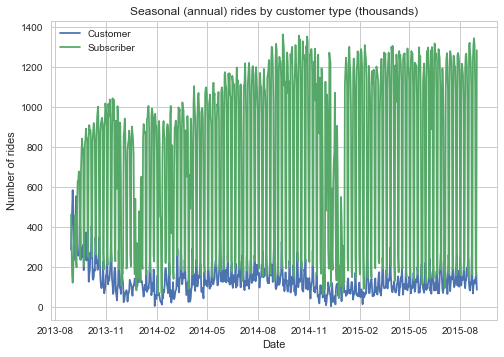

In [9]:
# Seasonal ridership by subscription model
t = df_trips.groupby([df_trips['start_date'].dt.date, 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of rides')
_ = plt.title('Seasonal (annual) rides by customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

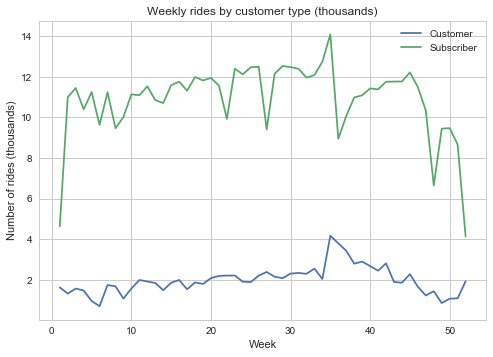

In [10]:
# Weekly ridership by subscription model
t = df_trips.groupby(['week', 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Weekly rides by customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

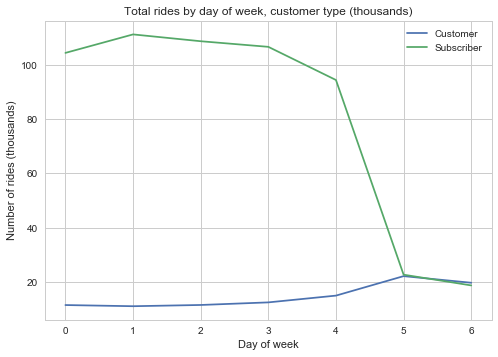

In [11]:
# Daily ridership by subscription model
t = df_trips.groupby(['dow', 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Day of week')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

In [12]:
# Hourly ridership by subscription model
t = df_trips.groupby(['hour', 'subscription_type']).size()
t = t.unstack('subscription_type')

sns.set_style("whitegrid")
_ = plt.plot(t/1000)
_ = plt.xlabel('Hour')
_ = plt.ylabel('Number of rides (thousands)')
_ = plt.title('Total rides by day of week, customer type (thousands)')
_ = plt.legend(['Customer','Subscriber'])
plt.show()

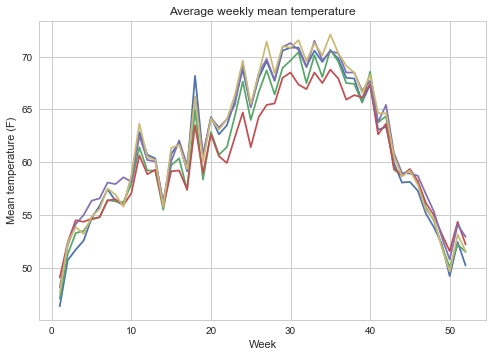

In [80]:
w = weather.groupby(['week', 'zip_code']).mean()
w = w.unstack('zip_code')

sns.set_style("whitegrid")
_ = plt.plot(w.mean_temperature_f)
_ = plt.xlabel('Week')
_ = plt.ylabel('Mean temperature (F)')
_ = plt.title('Average weekly mean temperature')
plt.show()

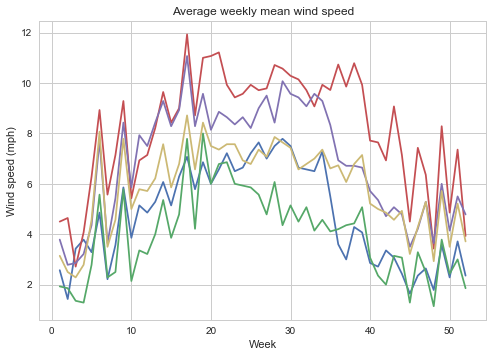

In [81]:
w = weather.groupby(['week', 'zip_code']).mean()
w = w.unstack('zip_code')

sns.set_style("whitegrid")
_ = plt.plot(w.mean_wind_speed_mph)
_ = plt.xlabel('Week')
_ = plt.ylabel('Wind speed (mph)')
_ = plt.title('Average weekly mean wind speed')
plt.show()

Now that we've understood the rough trends of data and user behavior, the next step is to build a simple deterministic model for predicting bike availability. From a rider's perspective, bike availability is a binary concern: Is a bike available? Yes or no. Thus, a binary classifier is appropriate. Note, from my experience, not all bikes in a bike share system are functional. Therefore, the classifier is adjusted slightly, and all models classify whether there are at least 2 bikes available at a station at a given time. 

As shown above, different stations exhibit different availability patterns. Stations in residential areas, for example, see a decrease in available bikes in the morning and in increase in bikes in the evening. Conversely, stations near offices see the reverse trend. This justifies a simplifying assumption for our predictive models: we can build independent models for each station, thereby explicitly choosing to omit correlations between the behavior of different stations.

# Data pipeline
All three models reply on preprocessing steps such as data filtering, harmonizing / simplifying data types, and feature engineering. To support easier recovery from kernel crashes, preprocessing is implemented Python scripts that persist output data.

Together, these transformation stages constitute a data pipeline that feed into the models. The six stages of the pipeline are: 

1. data/1/1-parse-date-time.py: Converts human-readable timestamp into epoch milliseconds.
    - Input schema (CSV): station_id,bikes_available,docks_available,timestamp
    - Output schema (CSV): station_id,bikes_available,docks_available,timestamp (epoch milliseconds)

2. data/2/2-generate-test-set.py: Generates a test dataset where rows satisy two conditions:
    - (1) day of month is less than given max day of month (e.g. if max_day_of_month <5, returned test set contains the 5 days of each month, ~13%)
    - (2) day of week equals the given day of week in ISO format(day_of_week = 3 since current deterministic model is calculated for Wednesday)
    - Input schema (CSV): station_id,bikes_available,docks_available,timestamp (epoch milliseconds)
    - Output schema (CSV): station_id,bikes_available,docks_available,timestamp(epoch milliseconds)

3. data/3/output.csv: Stored Jupyter output of the simple deterministic model.

4. data/4/4-map-model-time-to-status.py: Adds two new columns (1-appropriate model time; 2-true bike availability for t+30 minutes) for each row in the dataset if the timestamp of the row is within 30-minutes of a specified model time (in array). Otherwise, it drops the row from the dataset.
    - Input schema (CSV): station_id,bikes_available,docks_available,timestamp
    - Output schema (CSV): station_id, bikes_available, docks_available, timestamp, model_time, true_bikes_in_30_mins

5. data/5/5-generate-machine-learning-set2: Adds the following discretized datetime columns to the dataset: 
    - ISO day of week (1-7)
    - ISO month (1-12)
    - Commuter flags as 3 binary columns
		- non-commute hours (1/0)
		- AM commute (1/0) - status update between 7 and 09:00
		- PM commute (1/0) - status update between 16 and 18:00 
    - Input schema (CSV): station_id,bikes_available,docks_available,timestamp
    - Output schema (CSV): station_id,bikes_available,docks_available,timestamp, day_of_week, month, noncommute hours, AM_commute, PM_commute

6. data/6/6-generate-true-bikes-in-30-mins.py: Adds the true number of bikes at a station in t+30 mins.
    - Input schema (CSV): station_id,bikes_available,docks_available,timestamp, day_of_week, month, commute_hours
    - Output schema (CSV): station_id,bikes_available,docks_available,timestamp, day_of_week, month, commute_hours, true_bikes_in_30_mins

*** 
# Simple deterministic model
For comparison against the machine learning model, we create a deterministic model to calculate a per-station change in bike availability over nine 30-minute intervals. The change in bike availability is approximated using least squares -- which fits a curve that minimizes the sum of the squares of the difference between the dependent variable (bike availability) in the dataset and the value predicted by the linear function (where time = x). A simple least-squares model is shown below (Source: Wikipedia).

<img src ='images/least_sq.png'>

Core steps of model creation included: 
- The 30-minute intervals represent key commuter times (based on the daily traffic plotted in the EDA section above) when demand is highest: 
    - Morning: 7:30, 8, 8:30, 9am
    - Evening: 4, 4:30, 5, 5:30, 6pm
- The least squares fit line was calculated for each station and 30-minute interval 
- Predicted bike availability was calculated as the sum of: current bike availability and the slope of the least squares line (x 30 minutes)


Model evaluation is discussed below, along with the evaluation for the two machine learned models.

## Model creation

In [3]:
# initialize variables 
def func(x, a, b):
    return a + b*x
start_times = ['07:30:00', '08:00:00','08:30:00','09:00:00', 
               '16:00:00', '16:30:00','17:00:00','17:30:00','18:00:00']
delta = pd.Timedelta(29, unit='m')

station_ids = status.station_id.unique()
n_bikes = 2
dow = 2         # Wednesday (for datetime.dayofweek, Monday: 0)
dom = 9

In [4]:
# Subset the status dataset by station id
def station_availability(station_id, n_bikes, dow):    
    s = status[status.station_id == station_id]
    s.index = s['datetime']
    s.index = s.index.map(lambda x: x.replace(second=0))
    return s

In [140]:
popt_all_stations = []
row_headers = []

for i in station_ids:
    s = station_availability(i, n_bikes= n_bikes, dow= dow)       
    popt_single = []
    for j in start_times:
        start_time = pd.to_datetime(j)
        end_time = start_time + delta
        df = s.between_time(start_time.time(), end_time.time())
        xdata = df.index.minute
        ydata = np.array(df.bikes_available)
        popt, pcov = optimization.curve_fit(func, xdata, ydata)
        popt_single.append(popt[1])
    popt_all_stations.append(popt_single)
    row_headers.append(i)
    
# reshape model ouput with time as column headers, station as index
df = pd.DataFrame(popt_all_stations)
df.columns = start_times
df.index = row_headers

# Convert model from minute-by-minute change in bike availabilty --> total change during 
# model window (e.g. the 16:00 model applies to status updates between 16:00 and 16:29)
df = df*29

In [142]:
model = df
model['station_id'] = model.index
model = pd.melt(model, id_vars = ['station_id'])
model.head()

station_id  variable     value
0           2  07:30:00 -0.008874
1           3  07:30:00 -0.026502
2           4  07:30:00  0.179331
3           5  07:30:00  0.043489
4           6  07:30:00  0.735592

In [20]:
# export to csv (storage for kernel crash) 
model.to_csv('data/3/output.csv')

In [143]:
# import processed csv
df_eval = pd.read_csv('data/4/output.csv', header=None, 
                      names =['station_id','current_bikes','docks_available', 
                              'timestamp', 'model_time','actual_bikes_in_30'])

# Apply the model slope to calculate true number of bikes available in 30 mins (target variable)
df_eval = df_eval.merge(model, how='left', left_on= ['model_time','station_id'], 
                        right_on = ['variable','station_id'])

df_eval['actual_binary'] = df_eval.actual_bikes_in_30.apply(binary_bike_availability)
df_eval.rename(columns = {'value':'slope'}, inplace=True)
df_eval['predicted_bikes_in_30'] = df_eval.current_bikes + df_eval.slope
df_eval['predicted_binary'] = df_eval.predicted_bikes_in_30.apply(binary_bike_availability)
del df_eval['variable']

Now let's create the two machine learning models. We'll evaluate all three models together below.

***
# Machine Learning models

Steps 4, 5, and 6 of the data pipeline correspond to adding features to the dataset for both machine learned models. As mentioned above, in the mind of a rider, the issue of bike availability is binary. Riders do not care how many bikes are available, but rather is there *a* bike. In this case, we'll use a Random Forest Classifier, which will help use later tease apart the relative importance of our features.  

In [148]:
df_ml = pd.read_csv('data/6/output.csv', header=None, names =['station_id','current_bikes',
                                                              'docks_available', 'timestamp', 
                                                              'day_of_week', 'month', 'non_commute', 
                                                              'AM_commute', 'PM_commute', 
                                                              'actual_bikes_in_30'])
df_ml.head()

station_id  current_bikes  docks_available     timestamp  day_of_week  \
0           2              2               25  1.377796e+09            4   
1           2              2               25  1.377796e+09            4   
2           2              2               25  1.377796e+09            4   
3           2              2               25  1.377796e+09            4   
4           2              2               25  1.377796e+09            4   

   month  non_commute  AM_commute  PM_commute  actual_bikes_in_30  
0      8            1           0           0                   2  
1      8            1           0           0                   2  
2      8            1           0           0                   2  
3      8            1           0           0                   2  
4      8            1           0           0                   2

In [8]:
def binary_bike_availability(x):
    if x>=n_bikes: return 1
    else: return 0

In [149]:
# create binary target variable for bike availability
df_ml['y'] = df_ml.actual_bikes_in_30.apply(binary_bike_availability)

# remove columns used to generate target variable
del df_ml['timestamp'] 
del df_ml['docks_available']
del df_ml['actual_bikes_in_30']

## Station-specific random forest classifier
The first machine learning model uses simple features, engineered from the status timestamp: day of week, month, commute hours (non-commute, AM, or PM).

In [150]:
feature_imp = []
accuracy_list, recall_list, specificity_list, precision_list = [], [], [], []
tn_list, fp_list, fn_list, tp_list, length_list = [], [], [], [], []

for i in station_ids:
    # debug statements: report status during processing
    if i%10 == 0: print('Now handling station {}'.format(i))
        
    df_ml_subset = df_ml[df_ml.station_id == i]
    
    # create datasets for ML models: Y (target variable), X (features) 
    y = df_ml_subset.y.values
    X = df_ml_subset.drop(['y', 'station_id'], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 

    # impute and fit Random Forest Clasifier 
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    feature_imp.append(rfc.feature_importances_)
    y_pred = rfc.predict(X_test)
    
    # compute metrics for evaluation
    accuracy_list.append(rfc.score(X_test, y_test))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test,y_pred).ravel()
    
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
    total = tn + fp + fn + tp
    
    length_list.append(total)
    recall_list.append(tp/(tp+fn))
    specificity_list.append(tn/(tn+fp))
    precision_list.append(tp/(tp + fp))

Now handling station 10
Now handling station 30
Now handling station 50
Now handling station 60
Now handling station 70
Now handling station 80


The importance of each of the model's features are summarized below. Note there are 70 individual models (one per station). Using .describe(), we're able to also glean insights into the variance of feature importance across stations. Across the board, current bike availability is the most predictive feature of future bike availability. To a lesser degree, the month and day of week are predictive. Commute times play little importance.

In [195]:
pd.DataFrame(feature_imp, columns=X_train.columns).describe()

current_bikes  day_of_week      month  non_commute  AM_commute  \
count      70.000000    70.000000  70.000000    70.000000   70.000000   
mean        0.868503     0.045479   0.068561     0.006049    0.006551   
std         0.085010     0.032409   0.044790     0.005349    0.012826   
min         0.633807     0.003971   0.009582     0.000220    0.000295   
25%         0.806427     0.019050   0.029272     0.001666    0.002106   
50%         0.883224     0.037695   0.056562     0.004697    0.003561   
75%         0.946599     0.064181   0.102412     0.008851    0.006476   
max         0.978896     0.191970   0.160712     0.024694    0.103328   

       PM_commute  
count   70.000000  
mean     0.004856  
std      0.004180  
min      0.000063  
25%      0.001657  
50%      0.003622  
75%      0.007315  
max      0.018969

Now that we've seen a basic machine learning model, the next step is to add more sophisticated features with the hope of improving model performance. In particular, various aspects of weather (e.g. temperature, precipitation) are key determinants when commuters select their mode of transportation. In the next models we'll pull in a host of daily weather features.

## Machine learning model 2: Additional weather features
As with the first ML model, this model is station-specific. For a quick comparison, the weather-augmented model is created for a single station - station #2.

In [3]:
# clean up a subset of the df_ml dataframe for station #2
df_status_features = df_ml[df_ml.station_id ==2]

# create binary target variable for bike availability
df_status_features['y'] = df_status_features.actual_bikes_in_30.apply(binary_bike_availability)

df_status_features['datetime']=pd.to_datetime((df_status_features.timestamp.values*1e9).astype(int)).date
df_status_features = df_status_features.drop(['station_id', 'timestamp',
                                              'docks_available', 'actual_bikes_in_30'], axis = 1)
df_status_features.head()

Wrangle weather data into daily mean values for all features

In [103]:
df_daily_weather = pd.DataFrame.from_csv('data/0/weather.csv', index_col = None)

# drop max_gust_speed_mph due to spare data
df_daily_weather = df_daily_weather.drop(['max_gust_speed_mph'], axis = 1)

# clean up precipitation series (replace rogue T and nans)
df_daily_weather.precipitation_inches = df_daily_weather.precipitation_inches.replace('T', '0')
df_daily_weather.precipitation_inches = df_daily_weather.precipitation_inches.fillna(0)
df_daily_weather.precipitation_inches = df_daily_weather.precipitation_inches.astype('float')

# create daily mean value for all series across the 4 bay area zip codes
df_daily_weather = df_daily_weather.groupby(['date'], as_index=False).mean()
del df_daily_weather['zip_code']

df_daily_weather.date = pd.to_datetime(df_daily_weather.date).dt.date

Merge the status data frame with daily mean weather

In [105]:
df_test = pd.merge(df_status_features, df_daily_weather, how='inner',
                   left_on = 'datetime', right_on = 'date')

Create X and y datasets for machine learning, then impute and fit a random forest classifier.

In [122]:
# create datasets for ML models: Y (target variable), X (features) 
y = df_test.y.values
X = df_test.drop(['y', 'datetime','date'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 

# impute and fit Random Forest Clasifier 
rfc2 = RandomForestClassifier()
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)

In [123]:
features = pd.DataFrame(rfc2.feature_importances_,index=X_test.columns, columns=['Feature importance'])
features*100

Feature importance
current_bikes                            75.764318
day_of_week                               3.725547
month                                     0.319696
non_commute                               1.006500
AM_commute                                1.617477
PM_commute                                0.512253
max_temperature_f                         0.914432
mean_temperature_f                        0.389486
min_temperature_f                         0.714708
max_dew_point_f                           1.545145
mean_dew_point_f                          0.931289
min_dew_point_f                           1.319914
max_humidity                              1.254435
mean_humidity                             0.543517
min_humidity                              0.760837
max_sea_level_pressure_inches             0.977731
mean_sea_level_pressure_inches            0.715184
min_sea_level_pressure_inches             0.906070
max_visibility_miles                      0.122609
mean_visibility_miles                     0.820297
min_visibility_miles                      0.933415
max_wind_Speed_mph                        0.998717
mean_wind_speed_mph                       0.716651
precipitation_inches                      0.082560
cloud_cover                               1.569688
wind_dir_degrees                          0.837526

The above table shows the relative importance for the features in the weather-augmented model (i.e. both the original ML model features, as well as the additional new weather features). We can see that current bike availability is still far and beyond the best predictor of future bike availability. Day of week, AM commute, and non-commute hours are also decently important features from the original model. Of the newly-added weather features, cloud cover is the most important feature, followed by max dew point, min dew point, and max humidity. In a city with unpredictable weather and notorious cloud cover (I'm looking at you, Karl), it's no surprise that cloud cover impacts bike ridership (and therefor bike availability).

*In case you're not familiar with San Francisco, the daily fog is so intense and routine in summer, that it is fondly referred to as Karl.

# How do the models compare?
***
**Evaluating a model with class imbalance:** Accuracy is a commonly-used metric for evaluating models; however, it's not appropriate for models with severe class imbalance (e.g. where one class has a clear majority in the data), as is the case with bike share availability.  Only a small subset of the bike stations have insufficient bike availability during model times. In fact 96.6% of the stations have bikes available during the given time periods. Therefore, a classifier that predicted ALL stations have available bikes all the time would have 96% accuracy, but would be a horrible classifier. A confusion matrix provides a better assessment for classification:

<!-- <img src ='images/confusion_matrix.png'> -->

<!--|        | Predicted: No bikes  | Predicted: Bike availability | 
| :------------ |:-------------| :-----|
| Actual: No bikes| True negative (tn) |False positive (fp) | 
| Actual: Bike availability     | False negative (fn)|True positive (tp) | -->


|        | Actual positive (bikes)  | Actual negative (no bikes) | 
| :------------ |:-------------| :-----|
| Predicted positive (bikes)| True positive (tp) |False positive (fp) | 
| Predicted negative (no bikes)   | False negative (fn)|True negative (tn) | 

Multiple evaluation metrics can derived from the confusion matrix, including: 

True positive rate (recall, sensitivity): $$\frac {tp} {tp + fn}$$
True negative rate (specificity): $$\frac{tn}{tn+fp}$$
False positive rate: $$\frac{fp}{fp + tn} = 1 - specificity$$
False negative rate: $$\frac{fn}{fn + tp} = 1 - sensitivity$$
<!--Precision (positive predictive value): $$ \frac {tp} {tp + fp}$$-->
Accuracy: $$\frac {tp + tn} {tp + tn + fp + fn} $$
F1 score: $$\frac {2\times precision \times recall}{precision + recall}$$


From a rider's perspective the most important metric is the false positive rate: the ratio of the false positives (number of negative events wrongly categorized as positive) and the total number of actual negative events. In other words: If a model says a bike will be available in 30 minutes, will there actually be a bike at the station when the users arrive?

### Evaluation: Simple model

In [144]:
tn, fp, fn, tp = metrics.confusion_matrix(df_eval.actual_binary,df_eval.predicted_binary).ravel()
total = len(df_eval)

accuracy = metrics.accuracy_score(df_eval.actual_binary, df_eval.predicted_binary)
precision = tp / (tp + fp)
specificity = tn / (tn + fp)
recall = tp / (tp + fn)
fpr = fp / (fp + tn)
fnr = (1-precision) * (1-specificity)
f1 =(2*(precision*recall) / (precision+recall))

### Evaluation: Random forest classifier

In [151]:
# summarize the statistics calculated during model creation
length_array = np.array(length_list)
tn_ml = np.mean(np.array(tn_list)/length_array)
tp_ml = np.mean(np.array(tp_list)/length_array)
fp_ml = np.mean(np.array(fp_list)/length_array)
fn_ml = np.mean(np.array(fn_list)/length_array)
acc_ml = np.mean(accuracy_list)
prec_ml = np.mean(precision_list)
spec_ml = np.mean(specificity_list)
recall_ml = np.mean(recall_list)
fpr_ml = (1 - np.mean(specificity_list))
fnr_ml = (1-prec_ml)*(1 - spec_ml)

### Evaluation: Weather-augmented random forest classifier

In [128]:
tn_ml2, fp_ml2, fn_ml2, tp_ml2 = metrics.confusion_matrix(y_test,y_pred).ravel()
total_ml2 = tn_ml2 + fp_ml2 + fn_ml2 + tp_ml2

accuracy_ml2 = rfc2.score(X_test, y_test)
precision_ml2 = tp_ml2 / (tp_ml2 + fp_ml2)
specificity_ml2 = tn_ml2 / (tn_ml2 + fp_ml2)
recall_ml2 = tp_ml2 / (tp_ml2 + fn_ml2)
fpr_ml2 = fp_ml2 / (fp_ml2 + tn_ml2)
fnr_ml2 = (1-precision_ml2) * (1-specificity_ml2)
f1_ml2 =(2*(precision_ml2 * recall_ml2) / (precision_ml2 + recall_ml2))
# print(tn/total*100, fp/total*100, fn/total*100,  tp/total*100)

In [154]:
index = ['True negatives', 'False positives', 'False negatives', 'True positives', 
         'Accuracy','True positive rate (Recall)', 'True negative rate (Specificity)',
         'False positive rate', 'False negative rate']
data = {'Simple model': [tn/total, fp/total, fn/total, tp/total, accuracy, recall, specificity, fpr, fnr],
        'Random Forest': [tn_ml,fp_ml,fn_ml,tp_ml,acc_ml, recall_ml, spec_ml, fpr_ml, fnr_ml],
        'Random Forest + weather': [tn_ml2/total_ml2, fp_ml2/total_ml2, fn_ml2/total_ml2, tp_ml2/total_ml2, 
                                    accuracy_ml2, recall_ml2, specificity_ml2, fpr_ml2, fnr_ml2]}
     
evaluation = pd.DataFrame(data = data, index=index)
evaluation['Incremental'] = evaluation['Simple model']- evaluation['Random Forest'] 
evaluation.round(4) *100

Random Forest  Random Forest + weather  \
True negatives                             1.44                     0.25   
False positives                            0.71                     0.05   
False negatives                            0.33                     0.05   
True positives                            97.52                    99.65   
Accuracy                                  98.96                    99.90   
True positive rate (Recall)               99.65                    99.95   
True negative rate (Specificity)          71.09                    84.18   
False positive rate                       28.91                    15.82   
False negative rate                        0.21                     0.01   

                                  Simple model  Incremental  
True negatives                            1.24        -0.19  
False positives                           0.18        -0.53  
False negatives                           0.14        -0.19  
True positives                           98.44         0.92  
Accuracy                                 95.90        -3.05  
True positive rate (Recall)              97.26        -2.39  
True negative rate (Specificity)         56.93       -14.16  
False positive rate                      43.07        14.16  
False negative rate                       0.66         0.44

All three models report high accuracy (>95%), true positive rate / recall (>97%), and precision (>97%). 

For the most important metrics for users -- false positive rate and false negative rate -- both machine learned models outperforms the simple deterministic model. Specifically, the weather-augmented random forest model is far superior to the simple model in terms of false positive rate (one-third of the simple model's FPR) and false negative rate (0.01% vs. 0.66% for the simple model).  

# Possible extensions
This dataset holds rich potential for additional exploration, including engineering the following features: 
- Historical rate of change in bikes availability (e.g. slope of least-squares line like with simple model) 
- Leverage trip data for features around:
    - The number of rides started / ended at the station in the previous x-minute window. This could provide insights into station popularity that could otherwise be lost in the station status update (e.g. if 1 trip starts at Station A as another trip ends at Station A, the number of bikes available would be static)
    - Identify the most and least popular times for trips to start / end (e.g. take the first derivative to find local max & min of number of trips)
- Associate a zip code with each station, then map daily weather data at the zip-level rather than the Bay Area mean